# Training the Model, 2D

In [1]:
import numpy as np
import time
from scipy.special import gammaln
import torch

import scipy.stats as stats
import train_2D_rt as tr
import tools_2D_rt as tt

In [2]:
path = './training_data_quadvec/'

-----
# Generate Data


If you would prefer to read in pre-generated data, 

1. /home/mcarilli/CME/2D_CME/learning_environment/training_data_quadvec

has some files! 


In the generation, set the limits of grid calculation to be whatever you want-- it will store grids of MU+4STD. 

In [ ]:
set_size = 256
num_files = 20
N = num_files*set_size


params = tr.generate_param_vectors(N)

In [ ]:
def xmax_fun(xmax):

    return(4.5*xmax)

In [ ]:
#generate_sets(set_size,num_files,param_vectors,method,xmax_fun,NCOR,path_to_directory)
tr.generate_sets_pcme(set_size = 256,num_files=num_files,param_vectors = params,
                 method = 'quadvec',
                 xmax_fun=xmax_fun,
                 NCOR = 60,
                 path_to_directory=path)

-----

# Train Model

First, you can play around with your generating grids and get_ypred_at_RT function. 

In [3]:
def generate_grid(npdf,VAR,MU,quantiles=None,method='logn'):
    if quantiles=='PRESET':
        logstd = torch.sqrt(np.log((VAR/MU**2)+1))
        logmean = torch.log(MU**2/np.sqrt(VAR+MU**2))
        translin_0 = torch.exp(logmean[0]+logstd[0]*NORM_nas)
        translin_1 = torch.exp(logmean[1]+logstd[1]*NORM_mat)
        return translin_0,translin_1
        return(translin)

def get_ypred_at_RT(p,npdf,w,hyp=2.4, grid_method='logn',quantiles='PRESET',
                   first_special=False,special_std='tail_prob'):
    p = 10**p
    MU, VAR, STD, xmax = tr.get_moments(p)
    
    #two separate variables. a bit ugly and leaves room for error. 
    grid_nas,grid_mat = generate_grid(npdf,VAR,MU,method=grid_method,quantiles=quantiles) 
    # no zs implementation yet. not sure i want to implement it.

    s_nas = torch.zeros(npdf[0])
    s_mat = torch.zeros(npdf[1])

    spec = 0 if first_special else -1
    if first_special:
        s_nas[1:] = torch.diff(grid_nas)
        s_mat[1:] = torch.diff(grid_mat)
    else: #last special... for now
        s_nas[:-1] = torch.diff(grid_nas)
        s_mat[:-1] = torch.diff(grid_mat)
    
    if special_std == 'mean':
        s_nas[spec] = grid_nas[spec]
        s_mat[spec] = grid_mat[spec]
    elif special_std == 'neighbor': #assign_neighbor_to_special
        s_nas[spec] = s_nas[1] if first_special else s_nas[-2]
        s_mat[spec] = s_mat[1] if first_special else s_mat[-2]
    elif special_std == 'tail_prob':
        if first_special:
            print('If you are using this setting, you are doing something wrong.')
        t_max = torch.log(p[1]/p[2])/(p[1] - p[2])
        f = (torch.exp(-p[2]*t_max) - torch.exp(-p[1]*t_max)) * p[1]/(p[1] - p[2]) * p[0]
        tailratio = 1/(1+1/f) #the mature tail ratio
        s_mat[spec] = torch.sqrt(grid_mat[spec] / (1-tailratio))
        tailratio = p[0]/(1+p[0]) #the nascent tail ratio
        s_nas[spec] = torch.sqrt(grid_nas[spec] / (1-tailratio))
    else:
        print('did not specify a standard deviation convention!')
    
    s_nas *= hyp
    s_mat *= hyp
    v_nas = s_nas**2
    v_mat = s_mat**2

    r_nas = grid_nas**2/(v_nas-grid_nas)
    p_nas = 1-grid_nas/v_nas 
    r_mat = grid_mat**2/(v_mat-grid_mat)
    p_mat = 1-grid_mat/v_mat 
    
    xgrid_nas = torch.arange(xmax[0]+1)
    xgrid_mat = torch.arange(xmax[1]+1)
    
    gammaln_xgrid_nas = lnfactorial[1:(xmax[0]+2)]
    gammaln_xgrid_mat = lnfactorial[1:(xmax[1]+2)] 

    Y = torch.zeros((xmax[0]+1,xmax[1]+1))
    for i in range(npdf[0]):
        lnas = -grid_nas[i] + xgrid_nas * torch.log(grid_nas[i]) - gammaln_xgrid_nas
        if p_nas[i] > 1e-10:
            lnas += torch.special.gammaln(xgrid_nas+r_nas[i]) - torch.special.gammaln(r_nas[i]) \
                - xgrid_nas*torch.log(r_nas[i] + grid_nas[i]) + grid_nas[i] \
                + r_nas[i]*torch.log(1-p_nas[i])
        for j in range(npdf[1]):
            lmat =  - grid_mat[j] + xgrid_mat * torch.log(grid_mat[j]) - gammaln_xgrid_mat
            if p_mat[j] > 1e-10:
                lmat += torch.special.gammaln(xgrid_mat+r_mat[j]) - torch.special.gammaln(r_mat[j]) \
                - xgrid_mat*torch.log(r_mat[j] + grid_mat[j]) + grid_mat[j] \
                + r_mat[j]*torch.log(1-p_mat[j]) #wasteful: we're recomputing a lot of stuff.
            Y += w[i*npdf[1] + j] * torch.exp(lnas[:,None] + lmat[None,:])
            #note convention change. Y = the predicted PMF is now returned in the same shape as the original histogram.
            #this is fine bc Y is flattened anyway later on down the line.
    return Y

In [4]:
# define NORM and YPRED_FUN
npdf = np.array([10,11])

if npdf[0] == npdf[1]:
    n = np.arange(npdf[0])
    q = np.flip((np.cos((2*(n+1)-1)/(2*npdf)*np.pi)+1)/2)
    NORM = stats.norm.ppf(q)
    NORM_nas = torch.tensor(NORM)
    NORM_mat = NORM_nas
else:
    n = np.arange(npdf[0])
    q = np.flip((np.cos((2*(n+1)-1)/(2*npdf[0])*np.pi)+1)/2)
    print(q)
    NORM_nas = torch.tensor(stats.norm.ppf(q))
    n = np.arange(npdf[1])
    q = np.flip((np.cos((2*(n+1)-1)/(2*npdf[1])*np.pi)+1)/2)
    print(q)
    NORM_mat = torch.tensor(stats.norm.ppf(q))
    

n_n = np.linspace(0,1,npdf[0]+2)[1:-1]
n_m = np.linspace(0,1,npdf[1]+2)[1:-1]
NORM_nas = stats.norm.ppf(n_n)
NORM_mat = stats.norm.ppf(n_m)
print(NORM_nas)
lnfactorial = torch.special.gammaln(torch.arange(1003))

YPRED_FUN = lambda p, npdf, w: get_ypred_at_RT(p=p,npdf=npdf,w=w,hyp=2.4,
                                               grid_method='logn',quantiles='PRESET')

[0.00615583 0.05449674 0.14644661 0.27300475 0.42178277 0.57821723
 0.72699525 0.85355339 0.94550326 0.99384417]
[0.00508928 0.045184   0.12212521 0.22967959 0.35913372 0.5
 0.64086628 0.77032041 0.87787479 0.954816   0.99491072]
[-1.33517774 -0.90845787 -0.60458535 -0.3487557  -0.11418529  0.11418529
  0.3487557   0.60458535  0.90845787  1.33517774]


Next, train your model. You can choose number of epochs, number of training and testing files, 

You can also choose to train MLP1 or MLP2! :)))


In [16]:
# load in training, testing data 

train_list, test_list = tr.get_data(set_size=5120,number_of_training_files=1,
                                 number_of_testing_files=1,total_files=2,file_path=path)

In [14]:
import importlib
importlib.reload(tr)

<module 'train_2D_rt' from '/home/mcarilli/CME/2D_CME/learning_environment/train_2D_rt.py'>

In [19]:
t1 = time.time()

e,b,t,model = tr.train_MLP(train_list[:256],test_list[0:20],num_epochs=5,npdf=[10,11],
                           batchsize=256,
                           get_ypred_at_RT=YPRED_FUN,
                          metric = 'kld',MLP=1)

t2 = time.time()

print(t2-t1)

# if you want to save model

# torch.save(model.state_dict(), 'path/to/save/model')

1
Epoch Number: 0
Epoch Number: 1
Epoch Number: 2
Epoch Number: 3
Epoch Number: 4
53.787039279937744


In [20]:
#torch.save(model.state_dict(), './quadvec_models/10npdf_256params_qlin_MODEL')

Saving model:
torch.save(model.state_dict(), 'path/to/save/model')



Consequently loading it in: 

1. Define model: model = My_MLP1(3,npdf[0]*npdf[1]) or  model = My_MLP2(3,npdf[0]*npdf[1]) 
2. model.load_state_dict(torch.load('./path/to/model'))

In [ ]:
# model = my_MLP1(3,npdf[0]*npdf[1])
# model.load_state_dict(torch.load('./quad'))

# model.eval() -- maybe unneccessary? 

----
# Plotting

In [324]:
npdf = [50,51]
# pre-loaded model
model = tr.my_MLP1(3,npdf[0]*npdf[1])
model.load_state_dict(torch.load('./quadvec_models/50npdf_256params_qlin_MODEL'))
model.eval()
array = np.load('./quadvec_models/07032022_20npdf_1train_qlin_15epochs_et.npy',allow_pickle=True)
e = array[0]
t = array[1]
array2 = np.load('./quadvec_models/07032022_20npdf_1train_qlin_et.npy',allow_pickle=True)
e2 = array[0]
t2 = array[1]

In [294]:
import tools_2D_rt as tt
import importlib
importlib.reload(tt)

<module 'tools_2D_rt' from '/home/mcarilli/CME/2D_CME/learning_environment/tools_2D_rt.py'>

In [317]:
e2 = np.array([e2,e]).flatten()
t2 = np.array([t2,t]).flatten()

In [322]:
len(e)

5

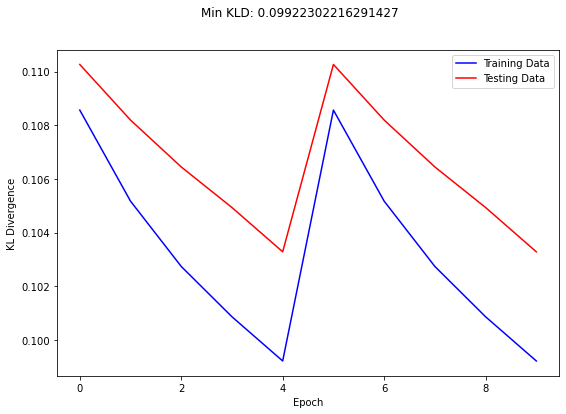

In [319]:
tt.plot_training(e2,t2)

### Plotting KLD histogram and CDF

In [278]:
klds, kld_mean = tr.calculate_test_klds(test_list=train_list,npdf= [20,21],
                                        model=model,get_ypred_at_RT=YPRED_FUN)

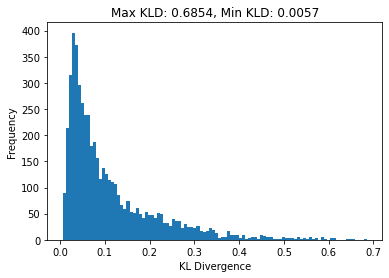

In [279]:
 tt.plot_histogram(klds,bins=100)

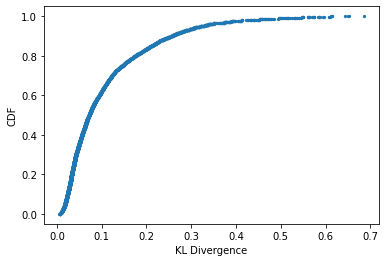

In [280]:
tt.plot_CDF(klds)

### Plotting Param Quantiles 

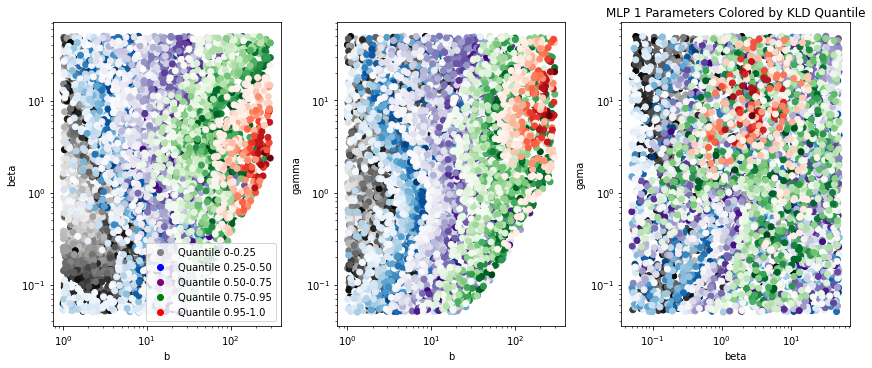

In [281]:
tt.plot_param_quantiles(klds,train_list,model)

### Plot PMFs

Random Grid of PMFs.

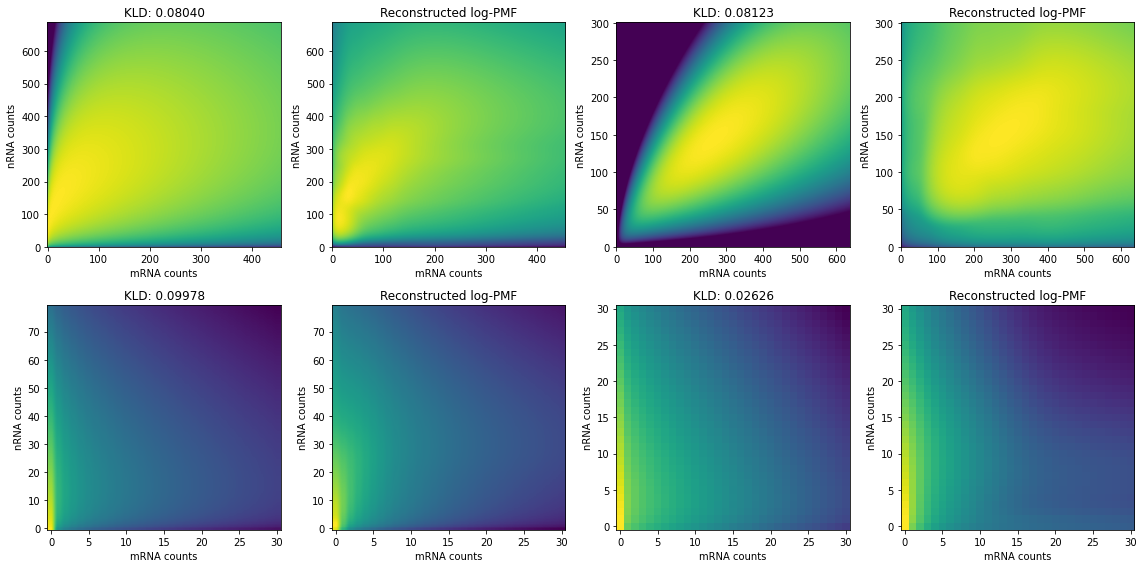

In [328]:
tt.plot_PMF_grid(file_list=test_list,npdf=[50,51],nrows=2,
                 ncols=2,model=model,get_ypred_at_RT=YPRED_FUN,kld=True)

Or plot specific PMF!

In [60]:
params,ys = tr.load_training_data(train_list)

KLD:  0.11487177759408951


tensor([ 1.0935,  0.3066, -1.2499])

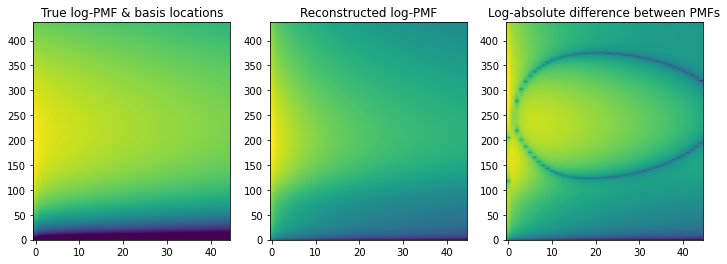

In [63]:
p_num = 30

tt.plot_PMF(params[p_num:p_num+1],ys[p_num],[10,11],model,get_ypred_at_RT)
params[p_num]

In [141]:
a = np.linspace(0,1,10+2)

In [144]:
b = a[1:-1]

In [145]:
b

array([0.09090909, 0.18181818, 0.27272727, 0.36363636, 0.45454545,
       0.54545455, 0.63636364, 0.72727273, 0.81818182, 0.90909091])